In [1]:
%pylab inline
from sklearn import linear_model
import cv2
from math import exp
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


<h2>Initial Parameters</h2>


Import simulated images

In [2]:
R = cv2.imread('./Images/ReferenceImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
N = cv2.imread('./Images/NewImage.jpg', cv2.CV_LOAD_IMAGE_GRAYSCALE) 
row_r, col_r = R.shape
row_n, col_n = N.shape
#vis = np.concatenate((R, N), axis=1)
#plt.imshow(vis, cmap="Greys_r")

Known image parameters (from simulation)

In [3]:
# Auxiliary functions to calculate PSFs
def gaussian(x, mu, sigma):
    return exp( -(((x-mu)/(sigma))**2)/2.0 )

def get_convolution_matrix(kernel_radius, sigma):
    # compute the kernel elements
    hkernel = [gaussian(x, kernel_radius, sigma) for x in range(2*kernel_radius+1)]
    vkernel = [x for x in hkernel]
    kernel2d = [[xh*xv for xh in hkernel] for xv in vkernel]

    # normalize the kernel elements
    kernelsum = sum([sum(row) for row in kernel2d])
    kernel2d = [[x/kernelsum for x in row] for row in kernel2d]

    return array(kernel2d)

In [4]:
# Authors specify in code that "noise must be a scalar for the entire image"
sigma_r = 100 #Std. deviation for noise in reference image
sigma_n = 100 #Std. deviation for noise in new image

# PSFs are being represented as tiles of convolution matrixes
tile_size = 15
sigma_PSF = 3.
PSF_r = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_r = np.tile(PSF_r, (row_r/tile_size, col_r/tile_size))
PSF_n = get_convolution_matrix((tile_size - 1)/2, sigma_PSF) 
PSF_n = np.tile(PSF_n, (row_n/tile_size, col_n/tile_size))

# constant = 0.11957153
# PSF_r = constant*ones((row_r, col_r))
# PSF_n = constant*ones((row_r, col_r))

Fourier transforms

In [5]:
fourier_R = fft.fft2(R)
fourier_N = fft.fft2(N)
fourier_PSF_r = fft.fft2(PSF_r)
fourier_PSF_n = fft.fft2(PSF_n)

<h2>Finding Beta</h2>

Parameters to calculate $\beta$, the ratio of Flux Based Zero Point of the Images

In [6]:
max_iter_beta = 10000 # maximum number of iterations for the fit
beta_epsilon = 0.001 # minimum distance for convergence of the fit
epsilon = 0.001 # avoids division by zero

Fit

In [7]:
# The fit is being donde through sklearn's linear regression
# It appears this is not a robust fit, which the article calls for
def linear_fit(D_r, D_n):
    D_r_elements = D_r.flatten().reshape(-1, 1) 
    D_n_elements = D_n.flatten().reshape(-1, 1) 
    lr_model = linear_model.LinearRegression().fit(D_r_elements, D_n_elements)
    slope = lr_model.coef_[0]
    intercept = lr_model.intercept_
    return slope, intercept

In [8]:
beta = 1
gamma_prime = 0

beta_converges = False
num_iter = 0

while not beta_converges and num_iter < max_iter_beta:
    num_iter = num_iter + 1
    denom = (beta**2)*(sigma_r**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) + (sigma_n**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
    fourier_D_n = (fourier_PSF_r*fourier_N)/sqrt(denom)
    fourier_D_r = (fourier_PSF_n*fourier_R)/sqrt(denom)
    
    D_n = ifft2(fourier_D_n)
    D_r = ifft2(fourier_D_r)
    
    # Here, they select pixels which are one (really three) sigma above the image noise
    # We don't do that
    
    prev_beta = beta
    # The fit we are using ignores imaginary parts, so we fit the squares instead 
    beta, gamma_prime = linear_fit(real(D_r*conjugate(D_r)), real(D_n*conjugate(D_n)))
    if abs(beta - prev_beta) < beta_epsilon:
        beta_converges = True
gamma = gamma_prime*sqrt(sigma_n**2 + (beta**2)*(sigma_r**2))

# The article claims the number of iterations is usually small (between two and three).
# This is true for this implementation
print('Number of iterations: ' + str(num_iter))
print('Beta: ' + str(beta))
print('Gamma: ' + str(gamma))

Number of iterations: 2
Beta: [ 1.00534089]
Gamma: [ 0.12962883]


<h2>Finding S</h2>

Assignment of Flux Based Zero Points

In [9]:
# Fs are assigned as the article suggests
F_r = 1
F_n = beta

Closed formula

In [10]:
denom = (sigma_r**2)*(F_n**2)*(fourier_PSF_n*conjugate(fourier_PSF_n)) 
denom = denom + (sigma_n**2)*(F_r**2)*(fourier_PSF_r*conjugate(fourier_PSF_r)) + epsilon
                               
fourier_S = (F_n)*(F_r**2)*conjugate(fourier_PSF_n)*(fourier_PSF_r*conjugate(fourier_PSF_r))*fourier_N
fourier_S = fourier_S - (F_r)*(F_n**2)*conjugate(fourier_PSF_r)*(fourier_PSF_n*conjugate(fourier_PSF_n))*fourier_R
fourier_S = fourier_S/denom
S = ifft2(fourier_S)

True

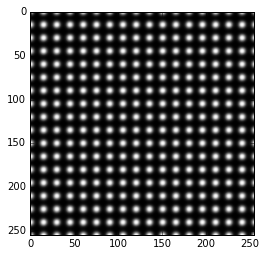

In [11]:
# We romove the imaginary parts from S by squaring it
# We also scale its histogram to 0-255
real_S = real(S*conjugate(S))
maximum_S = amax(real_S)

# We also scale its histogram to 0-255
real_S = (255/maximum_S)*real_S
maximum_S = amax(real_S)

plt.imshow(real_S, cmap="Greys_r")
cv2.imwrite('./Images/S.jpg', real_S)

Global Maxima

In [12]:
print("Maximum: " + str(maximum_S))
print("Points:")
for i in range(len(S)):
    for j in range(len(S)):
        if real_S[i][j] == maximum_S:
            print("(" + str(i) + "," + str(j) + ")")

Maximum: 255.0
Points:
(0,0)
(0,15)
(0,30)
(0,45)
(0,60)
(0,75)
(0,90)
(0,105)
(0,120)
(0,135)
(0,150)
(0,165)
(0,180)
(0,195)
(0,210)
(0,225)
(0,240)
(15,0)
(15,15)
(15,30)
(15,45)
(15,60)
(15,75)
(15,90)
(15,105)
(15,120)
(15,135)
(15,150)
(15,165)
(15,180)
(15,195)
(15,210)
(15,225)
(15,240)
(30,0)
(30,15)
(30,30)
(30,45)
(30,60)
(30,75)
(30,90)
(30,105)
(30,120)
(30,135)
(30,150)
(30,165)
(30,180)
(30,195)
(30,210)
(30,225)
(30,240)
(45,0)
(45,15)
(45,30)
(45,45)
(45,60)
(45,75)
(45,90)
(45,105)
(45,120)
(45,135)
(45,150)
(45,165)
(45,180)
(45,195)
(45,210)
(45,225)
(45,240)
(60,0)
(60,15)
(60,30)
(60,45)
(60,60)
(60,75)
(60,90)
(60,105)
(60,120)
(60,135)
(60,150)
(60,165)
(60,180)
(60,195)
(60,210)
(60,225)
(60,240)
(75,0)
(75,15)
(75,30)
(75,45)
(75,60)
(75,75)
(75,90)
(75,105)
(75,120)
(75,135)
(75,150)
(75,165)
(75,180)
(75,195)
(75,210)
(75,225)
(75,240)
(90,0)
(90,15)
(90,30)
(90,45)
(90,60)
(90,75)
(90,90)
(90,105)
(90,120)
(90,135)
(90,150)
(90,165)
(90,180)
(90,195)
(90,21

Local Maxima

In [13]:
# Ver http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html

Histograms

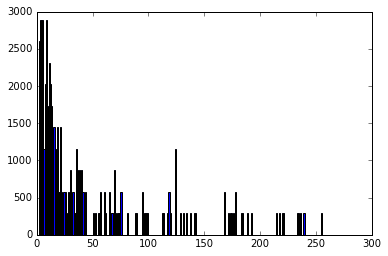

In [14]:
# Histogram of the complete S image
plt.hist(real_S.ravel(),256,[0,256]); 
plt.show()

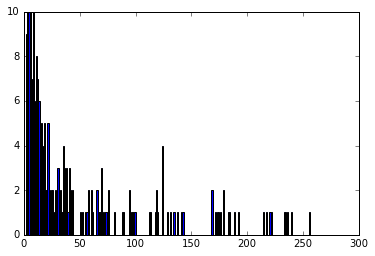

In [15]:
# Histogram of the central tile of the PSF
central_tile_bottom = row_r/2 - tile_size/2
central_tile_top = row_r/2 + tile_size/2
central_tile_left = col_r/2 - tile_size/2
central_tile_right = col_r/2 + tile_size/2
plt.hist(real_S[central_tile_bottom:central_tile_top+1, central_tile_left:central_tile_right+1].ravel(),256,[0,256]); 
plt.show()